# LORA fine tuning for Vision transformers

In this tutorial, you will fine-tune an ViT for images labelling using LORA. The dataset being used for fine tuning consists of images of food with a label of the "type" of food.

## Load dependancies

In [ ]:
!pip install accelerate evaluate datasets peft
# Load from transformers from github due to issue:
# https://github.com/huggingface/transformers/issues/34701
!pip install git+https://github.com/huggingface/transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-huv4dtr2

## Setup

For training and validation, we'll use the HuggingFace API. Additionally, we'll save the best model to your HuggingFace profile. To do this, you'll need to sign into HuggingFace using ```notebook_login()``` below. The Trainer API from HuggingFace abstracts away a number of infrastructure challanges e.g., half-precisions. To alter the wandb parameters of the Trainer API, we will use environment variables which are defined using ```os.environ```

In [ ]:
import wandb
import os
from tqdm import tqdm
os.environ["WANDB_PROJECT"] = "week10_tutorial"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [ ]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.48.0.dev0
Accelerate version: 1.1.1
PEFT version: 0.13.2


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## LORA overview
The aim of LORA is to reduce the memory and computational requirements of finetuning. When niavely training a model (i.e., without additional tricks), the entire model is placed on a GPU. However, since training requires computing gradients, this gradient information additionally needs to be stored on the GPU, further reducing the model size that can be trained. For a specific downstream task, LORA posits that additional updates to the weights of a network are defined by a subspace of the weights with rank significantly lower than the full weight matrix. Alternatively, for a specific downstream task, we are only interested in updating the weights in a subset of directions. A such, LORA posits freezing the base model weights and training an additional set of weights that will be added to the original weights. For a given weight matrix, the computation becomes: $h = W_{0}x + \Delta Wx = W_{0}x + \Delta BAx$ where $W_{0}$ is the original weight matrix and $W$ is the LORA weight, decomposed into $BA$. If $W_{0}\in \mathbb{R}^{d\times  k}$ then $B\in \mathbb{R}^{d\times  r}, A\in \mathbb{R}^{r\times  k}$. $r$ thus defines the rank of the LORA weight and defines a trade off between lower memory and higher computational speed (decreasing $r$) with increased learning capacity (increasing $r$). LORA additionally includes an $\alpha$ parameter which scales the learned weights ($BA$) when adding them to the base weights. This is generally set equal to the LORA rank however, a higher $\alpha$ will place greater emphasis on the learned weights.

## Import and setup data

In [ ]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [ ]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:5000]")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'baklava'

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

## Model training

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print_trainable_parameters(model)

trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


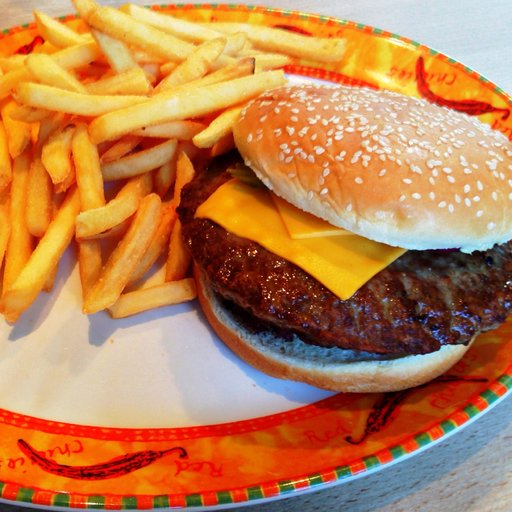

In [ ]:
test_image = train_ds[0]["image"]
test_image

In [ ]:
encoding = image_processor(test_image.convert("RGB"), return_tensors="pt")
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: churros


In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 667493 || all params: 86543818 || trainable%: 0.77


In [ ]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    eval_strategy="epoch", # How often to evaluate the model on the validation set i.e., after every epoch
    save_strategy="epoch", # How often to save model checkpoints i.e., after every epoch
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size, # Effective batch size (equals the actual batch size when using a single GPU)
    gradient_accumulation_steps=4, #
    per_device_eval_batch_size=batch_size, # Effective batch size (equals the actual batch size when using a single GPU)
    fp16=True, # Train with floating point 16, reducing the memory requirements
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
    report_to="wandb"
)

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
preds = []
gt = []
model = model.cuda()
for i in tqdm(val_ds):
  _encoding = image_processor(i["image"].convert("RGB"), return_tensors="pt")
  with torch.no_grad():
    outputs = model(pixel_values=_encoding["pixel_values"].cuda())
    logits = outputs.logits

  predicted_class_idx = logits.argmax(-1).item()
  preds.append(predicted_class_idx)
  gt.append(i["label"])
gt = torch.tensor(gt).reshape(-1,1)
preds = torch.tensor(preds).reshape(-1,1)
pt_acc = metric.compute(predictions=preds, references=gt)["accuracy"]
print(f"Validation accuracy prior to training: {pt_acc}")

100%|██████████| 500/500 [00:18<00:00, 26.36it/s]

Validation accuracy prior to training: 0.002


In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [ ]:
train_results = trainer.train()
wandb.finish()

wandb: Currently logged in as: joshuaspear (jsphd). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.553314,0.858000
2,8.786500,0.154536,0.952000
3,1.287800,0.107992,0.964000
4,0.763800,0.117047,0.966000
5,0.637800,0.109828,0.966000


wandb: Adding directory to artifact (./vit-base-patch16-224-in21k-finetuned-lora-food101/checkpoint-9)... Done. 0.0s
wandb: Adding directory to artifact (./vit-base-patch16-224-in21k-finetuned-lora-food101/checkpoint-18)... Done. 0.0s
wandb: Adding directory to artifact (./vit-base-patch16-224-in21k-finetuned-lora-food101/checkpoint-27)... Done. 0.0s
wandb: Adding directory to artifact (./vit-base-patch16-224-in21k-finetuned-lora-food101/checkpoint-36)... Done. 0.0s
wandb: Adding directory to artifact (./vit-base-patch16-224-in21k-finetuned-lora-food101/checkpoint-45)... Done. 0.0s
wandb: Adding directory to artifact (./vit-base-patch16-224-in21k-finetuned-lora-food101/checkpoint-45)... Done. 0.0s
No files have been modified since last commit. Skipping to prevent empty commit.


eval/accuracy,▁▇███
eval/loss,█▂▁▁▁
eval/runtime,█▁▃▂▁
eval/samples_per_second,▁█▅▇█
eval/steps_per_second,▁█▅▇█
train/epoch,▁▁▃▃▅▅▆▇██
train/global_step,▁▁▃▃▅▅▆▇██
train/grad_norm,█▂▂▁
train/learning_rate,█▆▃▁
train/loss,█▂▁▁
eval/accuracy,0.966


In [ ]:
repo_name = f"joshuaspear/{model_name}-finetuned-lora-food101"
lora_model.push_to_hub(repo_name)

README.md:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/joshuaspear/vit-base-patch16-224-in21k-finetuned-lora-food101/commit/2ffe7a0856febd6c86e7f051ed0cfb33fbc95c1b', commit_message='Upload model', commit_description='', oid='2ffe7a0856febd6c86e7f051ed0cfb33fbc95c1b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/joshuaspear/vit-base-patch16-224-in21k-finetuned-lora-food101', endpoint='https://huggingface.co', repo_type='model', repo_id='joshuaspear/vit-base-patch16-224-in21k-finetuned-lora-food101'), pr_revision=None, pr_num=None)

In [ ]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, repo_name)
image_processor = AutoImageProcessor.from_pretrained(repo_name)

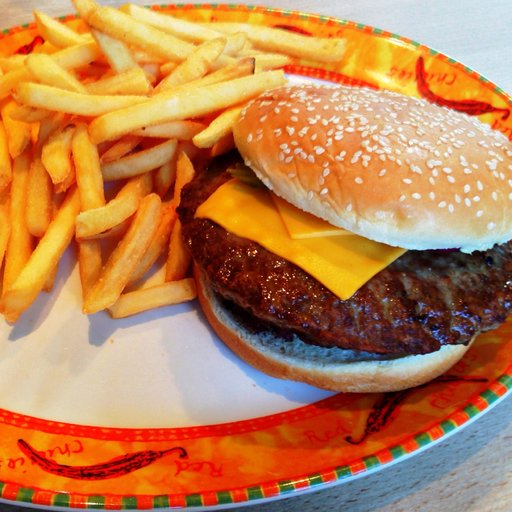

In [ ]:
train_ds[0]["image"]

In [ ]:
encoding = image_processor(train_ds[0]["image"].convert("RGB"), return_tensors="pt")
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: hamburger


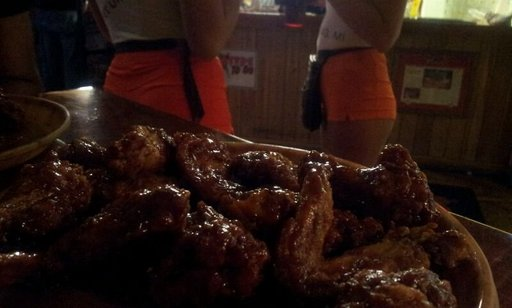

In [ ]:
train_ds[1]["image"]

In [ ]:
encoding = image_processor(train_ds[1]["image"].convert("RGB"), return_tensors="pt")
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: chicken_wings
